**The procedure taken in this notebook is similar to the one we took for reference dataset**

In [1]:
import os

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import sys
import scanpy as sc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scarches as sca
import anndata as ad
from scipy import sparse
import gdown
import gzip
import shutil
import urllib.request
from sklearn import preprocessing

2023-07-01 00:16:03.799446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 captum (see https://github.com/pytorch/captum).


We download a small dataset from the link below to be used as query dataset:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171668

There is no direct link for downloading the .h5 files so i just downloaded them manually and put it in the same directory.

In [3]:
path_query_data = "02-P005175-S022-R01_out_FPR_0.01_filtered.h5"
adata_query_unprep = sc.read_10x_h5(path_query_data)

adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

del adata_query_unprep.obsm
del adata_query_unprep.varm

In [4]:
adata_query_unprep.var_names_make_unique()


var = adata_query_unprep.var
var.index.unique()

Index(['GRCh38premrna_MIR1302-2HG', 'GRCh38premrna_FAM138A',
       'GRCh38premrna_OR4F5', 'GRCh38premrna_AL627309.1',
       'GRCh38premrna_AL627309.3', 'GRCh38premrna_AL627309.2',
       'GRCh38premrna_AL627309.4', 'GRCh38premrna_AL732372.1',
       'GRCh38premrna_OR4F29', 'GRCh38premrna_AC114498.1',
       ...
       'SARSCoV2______SARSCoV2_E', 'SARSCoV2______SARSCoV2_M',
       'SARSCoV2______SARSCoV2_ORF6', 'SARSCoV2______SARSCoV2_ORF7a',
       'SARSCoV2______SARSCoV2_ORF7b', 'SARSCoV2______SARSCoV2_ORF8',
       'SARSCoV2______SARSCoV2_N', 'SARSCoV2______SARSCoV2_ORF10',
       'SARSCoV2______SARSCoV2_3prime', 'SARSCoV2______SARSCoV2_NegStrand'],
      dtype='object', length=33567)

# Preprocess 

## Trying to organize features (genes)


Check the 'gene_id's in reference model

In [5]:
path_gene_mapping_df = os.path.join("./", "HLCA_reference_model_gene_order_ids_and_symbols.csv")
# url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv"
# gdown.download(url, path_gene_mapping_df, quiet=False)

In [6]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)
gene_ids = gene_id_to_gene_name_df.sort_index().index.values
gene_ids

array(['ENSG00000000938', 'ENSG00000000971', 'ENSG00000002587',
       'ENSG00000002933', 'ENSG00000003436', 'ENSG00000004776',
       'ENSG00000004799', ..., 'ENSG00000278196', 'ENSG00000279576',
       'ENSG00000280721', 'ENSG00000281103', 'ENSG00000282122',
       'ENSG00000282988', 'ENSG00000283063'], dtype=object)

In [7]:
def extract_name(s):
    string = s["gene_ids"]
    return string[string.find("ENSG"):]

adata_query_unprep.var["gene_names"] = adata_query_unprep.var.apply(extract_name, axis=1)

gene_name_column_name = "gene_names"

n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_id_to_gene_name_df.index)
    .sum()
)
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)

Number of model input genes detected: 1993 out of 2000 (100%)


In [8]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_id_to_gene_name_df.index
    ),
].copy()  # subset your data to genes used in the references model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_id_to_gene_name_df.index, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index

In [9]:
adata_query_unprep

AnnData object with n_obs × n_vars = 2142 × 1993
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

In [10]:
var = adata_query_unprep.var
not_in_query = set(gene_ids) - set(var.index.values)
in_mapping = set(gene_ids) - not_in_query
cells_names = adata_query_unprep.obs.index.values

Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index and in a .var[gene_ids] (for merging duplicate genes).

In [11]:
adata_query_unprep.var.head(3)

gene_ids    feature_types         genome  \
ENSG00000188290  ENSG00000188290  Gene Expression  GRCh38premrna   
ENSG00000187608  ENSG00000187608  Gene Expression  GRCh38premrna   
ENSG00000162571  ENSG00000162571  Gene Expression  GRCh38premrna   

                      gene_names  
ENSG00000188290  ENSG00000188290  
ENSG00000187608  ENSG00000187608  
ENSG00000162571  ENSG00000162571

In [12]:
var = var.copy()
for gene_id in not_in_query:
    var.loc[gene_id] = [gene_id, "Gene Expression", "GRCh38premrna", gene_id]
var

gene_ids    feature_types         genome  \
ENSG00000188290  ENSG00000188290  Gene Expression  GRCh38premrna   
ENSG00000187608  ENSG00000187608  Gene Expression  GRCh38premrna   
ENSG00000162571  ENSG00000162571  Gene Expression  GRCh38premrna   
ENSG00000186891  ENSG00000186891  Gene Expression  GRCh38premrna   
ENSG00000186827  ENSG00000186827  Gene Expression  GRCh38premrna   
...                          ...              ...            ...   
ENSG00000279576  ENSG00000279576  Gene Expression  GRCh38premrna   
ENSG00000274961  ENSG00000274961  Gene Expression  GRCh38premrna   
ENSG00000253701  ENSG00000253701  Gene Expression  GRCh38premrna   
ENSG00000267453  ENSG00000267453  Gene Expression  GRCh38premrna   
ENSG00000231721  ENSG00000231721  Gene Expression  GRCh38premrna   

                      gene_names  
ENSG00000188290  ENSG00000188290  
ENSG00000187608  ENSG00000187608  
ENSG00000162571  ENSG00000162571  
ENSG00000186891  ENSG00000186891  
ENSG00000186827  ENSG00000186827  
...                          ...  
ENSG00000279576  ENSG00000279576  
ENSG00000274961  ENSG00000274961  
ENSG00000253701  ENSG00000253701  
ENSG00000267453  ENSG00000267453  
ENSG00000231721  ENSG00000231721  

[2000 rows x 4 columns]

In [13]:
in_mapping_index = var.reset_index().reset_index().set_index("gene_ids", drop=False).sort_index()["level_0"].values
in_mapping_index

array([  41,  208,  491,  872,  348, 1842,  832, ..., 1936, 1995,  276,
        804, 1462,  681,  857])

In [14]:
# Why we did above? sort genes by their names once for all
var.sort_index()

gene_ids    feature_types         genome  \
ENSG00000000938  ENSG00000000938  Gene Expression  GRCh38premrna   
ENSG00000000971  ENSG00000000971  Gene Expression  GRCh38premrna   
ENSG00000002587  ENSG00000002587  Gene Expression  GRCh38premrna   
ENSG00000002933  ENSG00000002933  Gene Expression  GRCh38premrna   
ENSG00000003436  ENSG00000003436  Gene Expression  GRCh38premrna   
...                          ...              ...            ...   
ENSG00000280721  ENSG00000280721  Gene Expression  GRCh38premrna   
ENSG00000281103  ENSG00000281103  Gene Expression  GRCh38premrna   
ENSG00000282122  ENSG00000282122  Gene Expression  GRCh38premrna   
ENSG00000282988  ENSG00000282988  Gene Expression  GRCh38premrna   
ENSG00000283063  ENSG00000283063  Gene Expression  GRCh38premrna   

                      gene_names  
ENSG00000000938  ENSG00000000938  
ENSG00000000971  ENSG00000000971  
ENSG00000002587  ENSG00000002587  
ENSG00000002933  ENSG00000002933  
ENSG00000003436  ENSG00000003436  
...                          ...  
ENSG00000280721  ENSG00000280721  
ENSG00000281103  ENSG00000281103  
ENSG00000282122  ENSG00000282122  
ENSG00000282988  ENSG00000282988  
ENSG00000283063  ENSG00000283063  

[2000 rows x 4 columns]

In [15]:
# does the same but faster
var.iloc[in_mapping_index]

gene_ids    feature_types         genome  \
ENSG00000000938  ENSG00000000938  Gene Expression  GRCh38premrna   
ENSG00000000971  ENSG00000000971  Gene Expression  GRCh38premrna   
ENSG00000002587  ENSG00000002587  Gene Expression  GRCh38premrna   
ENSG00000002933  ENSG00000002933  Gene Expression  GRCh38premrna   
ENSG00000003436  ENSG00000003436  Gene Expression  GRCh38premrna   
...                          ...              ...            ...   
ENSG00000280721  ENSG00000280721  Gene Expression  GRCh38premrna   
ENSG00000281103  ENSG00000281103  Gene Expression  GRCh38premrna   
ENSG00000282122  ENSG00000282122  Gene Expression  GRCh38premrna   
ENSG00000282988  ENSG00000282988  Gene Expression  GRCh38premrna   
ENSG00000283063  ENSG00000283063  Gene Expression  GRCh38premrna   

                      gene_names  
ENSG00000000938  ENSG00000000938  
ENSG00000000971  ENSG00000000971  
ENSG00000002587  ENSG00000002587  
ENSG00000002933  ENSG00000002933  
ENSG00000003436  ENSG00000003436  
...                          ...  
ENSG00000280721  ENSG00000280721  
ENSG00000281103  ENSG00000281103  
ENSG00000282122  ENSG00000282122  
ENSG00000282988  ENSG00000282988  
ENSG00000283063  ENSG00000283063  

[2000 rows x 4 columns]

In [16]:
# changing the order of columns
gene_expression = adata_query_unprep.X

In [17]:
list_input = [None] * gene_expression.shape[0]
for i in tqdm(range(gene_expression.shape[0])):
    tmp = gene_expression[i].toarray()[0].astype(int)
    tmp = np.concatenate([np.array(tmp), np.array([0] * len(not_in_query))])
    list_input[i] = tmp[in_mapping_index]

100%|█████████████████████████████████████████████████████████████████████████████| 2142/2142 [00:00<00:00, 9968.76it/s]


In [18]:
input_to_model = pd.DataFrame({
    "index":cells_names,
    "input_ids":list_input,
    "label": 0,
    "length": 2000
})
input_to_model

index                                          input_ids  \
0     GGTGTCGTCCACCTCA-1  [0, 5, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
1     CATTCCGGTCGAACGA-1  [0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, ...   
2     TCACAAGAGACAGCGT-1  [0, 5, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     AGAGAATAGAAGCTGC-1  [0, 9, 0, 13, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...   
4     ACACAGTAGGCCATAG-1  [0, 33, 0, 2, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                  ...                                                ...   
2137  CTATCTAAGGTTGGAC-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2138  CATCCCACATACAGAA-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2139  TCGATTTAGTAATACG-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2140  TGGTAGTCAGAACATA-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2141  TAGTGCATCAAGTTGC-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

      label  length  
0         0    2000  
1         0    2000  
2         0    2000  
3         0    2000  
4         0    2000  
...     ...     ...  
2137      0    2000  
2138      0    2000  
2139      0    2000  
2140      0    2000  
2141      0    2000  

[2142 rows x 4 columns]

## Adding Labels from metadata

There is a brief metadata available in the source page. We use that to find as many labels as we can for our query set.

(The data downloaded as query set contains cells from Liver.)

In [19]:
df = pd.read_csv("GSE171668_liver_metadata.csv")

In [20]:
look_for = "02-P005175-S022-R01"
query_reads = df[df["barcodes"].str.find(look_for) != -1].copy()
query_reads["barcodes"] = query_reads["barcodes"].str.split("-").str[-1] + "-1"
query_reads = query_reads.set_index("barcodes")
query_reads

donor  n_genes  n_counts  percent_mito  method  doublet  \
barcodes                                                                     
AAAGGATTCGGCCAAC-1    D1      380       546     14.835165  nuclei    False   
AAAGTCCGTAACGCGA-1    D1      386       491      9.775967  nuclei    False   
AAAGTGACAGAGACTG-1    D1      730       907      2.866593  nuclei    False   
AAAGTGAGTGGACCAA-1    D1      538       816     14.093137  nuclei    False   
AACAAGACAAATACAG-1    D1     2115      3780      0.026455  nuclei    False   
...                  ...      ...       ...           ...     ...      ...   
TTTCGATTCAAACGAA-1    D1     2123      4249      8.001883  nuclei    False   
TTTGATCAGTGTGTTC-1    D1      403       530     15.283019  nuclei    False   
TTTGATCGTAGGGTAC-1    D1      692       953      8.604407  nuclei    False   
TTTGATCGTAGTGGCA-1    D1      690       910      0.659341  nuclei    False   
TTTGGTTCACCCTGAG-1    D1      590       745      7.516779  nuclei    False   

                   predicted_celltype                 manual_annotation  
barcodes                                                                 
AAAGGATTCGGCCAAC-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
AAAGTCCGTAACGCGA-1         fibroblast         CP+Periportal hepatocytes  
AAAGTGACAGAGACTG-1         hepatocyte         CP+Periportal hepatocytes  
AAAGTGAGTGGACCAA-1         hepatocyte              Mito-rich hepatocyte  
AACAAGACAAATACAG-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
...                               ...                               ...  
TTTCGATTCAAACGAA-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCAGTGTGTTC-1         macrophage      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGGGTAC-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGTGGCA-1         hepatocyte         CP+Periportal hepatocytes  
TTTGGTTCACCCTGAG-1         macrophage  LSEC/Hepatocyte Doublet (immune)  

[482 rows x 8 columns]

In [21]:
query_reads

donor  n_genes  n_counts  percent_mito  method  doublet  \
barcodes                                                                     
AAAGGATTCGGCCAAC-1    D1      380       546     14.835165  nuclei    False   
AAAGTCCGTAACGCGA-1    D1      386       491      9.775967  nuclei    False   
AAAGTGACAGAGACTG-1    D1      730       907      2.866593  nuclei    False   
AAAGTGAGTGGACCAA-1    D1      538       816     14.093137  nuclei    False   
AACAAGACAAATACAG-1    D1     2115      3780      0.026455  nuclei    False   
...                  ...      ...       ...           ...     ...      ...   
TTTCGATTCAAACGAA-1    D1     2123      4249      8.001883  nuclei    False   
TTTGATCAGTGTGTTC-1    D1      403       530     15.283019  nuclei    False   
TTTGATCGTAGGGTAC-1    D1      692       953      8.604407  nuclei    False   
TTTGATCGTAGTGGCA-1    D1      690       910      0.659341  nuclei    False   
TTTGGTTCACCCTGAG-1    D1      590       745      7.516779  nuclei    False   

                   predicted_celltype                 manual_annotation  
barcodes                                                                 
AAAGGATTCGGCCAAC-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
AAAGTCCGTAACGCGA-1         fibroblast         CP+Periportal hepatocytes  
AAAGTGACAGAGACTG-1         hepatocyte         CP+Periportal hepatocytes  
AAAGTGAGTGGACCAA-1         hepatocyte              Mito-rich hepatocyte  
AACAAGACAAATACAG-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
...                               ...                               ...  
TTTCGATTCAAACGAA-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCAGTGTGTTC-1         macrophage      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGGGTAC-1         hepatocyte      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGTGGCA-1         hepatocyte         CP+Periportal hepatocytes  
TTTGGTTCACCCTGAG-1         macrophage  LSEC/Hepatocyte Doublet (immune)  

[482 rows x 8 columns]

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(query_reads["predicted_celltype"].values)

query_reads["predicted_celltype"] = le.fit_transform(query_reads["predicted_celltype"].values)
query_reads

donor  n_genes  n_counts  percent_mito  method  doublet  \
barcodes                                                                     
AAAGGATTCGGCCAAC-1    D1      380       546     14.835165  nuclei    False   
AAAGTCCGTAACGCGA-1    D1      386       491      9.775967  nuclei    False   
AAAGTGACAGAGACTG-1    D1      730       907      2.866593  nuclei    False   
AAAGTGAGTGGACCAA-1    D1      538       816     14.093137  nuclei    False   
AACAAGACAAATACAG-1    D1     2115      3780      0.026455  nuclei    False   
...                  ...      ...       ...           ...     ...      ...   
TTTCGATTCAAACGAA-1    D1     2123      4249      8.001883  nuclei    False   
TTTGATCAGTGTGTTC-1    D1      403       530     15.283019  nuclei    False   
TTTGATCGTAGGGTAC-1    D1      692       953      8.604407  nuclei    False   
TTTGATCGTAGTGGCA-1    D1      690       910      0.659341  nuclei    False   
TTTGGTTCACCCTGAG-1    D1      590       745      7.516779  nuclei    False   

                    predicted_celltype                 manual_annotation  
barcodes                                                                  
AAAGGATTCGGCCAAC-1                   4      APOA1+APOA2+TTR+Hepatocyte-1  
AAAGTCCGTAACGCGA-1                   3         CP+Periportal hepatocytes  
AAAGTGACAGAGACTG-1                   4         CP+Periportal hepatocytes  
AAAGTGAGTGGACCAA-1                   4              Mito-rich hepatocyte  
AACAAGACAAATACAG-1                   4      APOA1+APOA2+TTR+Hepatocyte-1  
...                                ...                               ...  
TTTCGATTCAAACGAA-1                   4      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCAGTGTGTTC-1                   6      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGGGTAC-1                   4      APOA1+APOA2+TTR+Hepatocyte-1  
TTTGATCGTAGTGGCA-1                   4         CP+Periportal hepatocytes  
TTTGGTTCACCCTGAG-1                   6  LSEC/Hepatocyte Doublet (immune)  

[482 rows x 8 columns]

In [23]:
len(le.classes_)

15

In [24]:
input_to_model['label'] = input_to_model['index'].map(query_reads['predicted_celltype'])
input_to_model['label'] = input_to_model['label'].fillna(int(len(le.classes_)+1))
input_to_model

index                                          input_ids  \
0     GGTGTCGTCCACCTCA-1  [0, 5, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
1     CATTCCGGTCGAACGA-1  [0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, ...   
2     TCACAAGAGACAGCGT-1  [0, 5, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     AGAGAATAGAAGCTGC-1  [0, 9, 0, 13, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...   
4     ACACAGTAGGCCATAG-1  [0, 33, 0, 2, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                  ...                                                ...   
2137  CTATCTAAGGTTGGAC-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2138  CATCCCACATACAGAA-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2139  TCGATTTAGTAATACG-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2140  TGGTAGTCAGAACATA-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2141  TAGTGCATCAAGTTGC-1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

      label  length  
0      16.0    2000  
1      16.0    2000  
2      16.0    2000  
3      16.0    2000  
4      16.0    2000  
...     ...     ...  
2137   16.0    2000  
2138   16.0    2000  
2139   16.0    2000  
2140   16.0    2000  
2141   16.0    2000  

[2142 rows x 4 columns]

# Pass to Geneformer

In [25]:
import geneformer

from collections import Counter
import datetime
import pickle
import subprocess
import seaborn as sns; 
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:10

In [26]:
hg_dataset = Dataset(pa.Table.from_pandas(input_to_model))
hg_dataset.save_to_disk('query_hg')

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training parameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 0
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 16
# batch size for training and eval
geneformer_batch_size = 16
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 10
# optimizer
optimizer = "adamw"

In [28]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained("./model", 
                                                  num_labels=50,
                                                  output_attentions = False,
                                                  output_hidden_states = False).to("cuda")

Some weights of the model checkpoint at ./model were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./model and are newly initialized: ['

In [29]:
training_args = {
    "learning_rate": max_lr,
    "do_train": False,
    "do_eval": False,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
#     "logging_steps": "logging_steps",
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "output_dir": "./output",
}
training_args_init = TrainingArguments(**training_args)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=input_to_model,
    eval_dataset=input_to_model,
    compute_metrics=compute_metrics
)

In [31]:
out = trainer.predict(hg_dataset)

In [32]:
import umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(out.predictions)
embedding_df = pd.DataFrame(umap_embedding)

Saving the dataset (0/1 shards):   0%|          | 0/2142 [00:00<?, ? examples/s]

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/uma

In [33]:
embedding_df["label"] = input_to_model["label"]

In [34]:
embedding_df["label"] = embedding_df["label"].apply(
    lambda x: le.inverse_transform([int(x)])[0] if x < len(le.classes_) else "Unknown"
)
embedding_df

0         1    label
0     -3.904718  5.855416  Unknown
1     -4.474716  7.836582  Unknown
2     -4.761762  7.823586  Unknown
3     -5.211682  8.302266  Unknown
4     -5.278366  8.457975  Unknown
...         ...       ...      ...
2137  13.149062  4.989830  Unknown
2138   1.154084  0.141842  Unknown
2139  10.430656 -2.631399  Unknown
2140  13.145921  4.986733  Unknown
2141  13.137566  4.979125  Unknown

[2142 rows x 3 columns]

<Axes: xlabel='1', ylabel='0'>

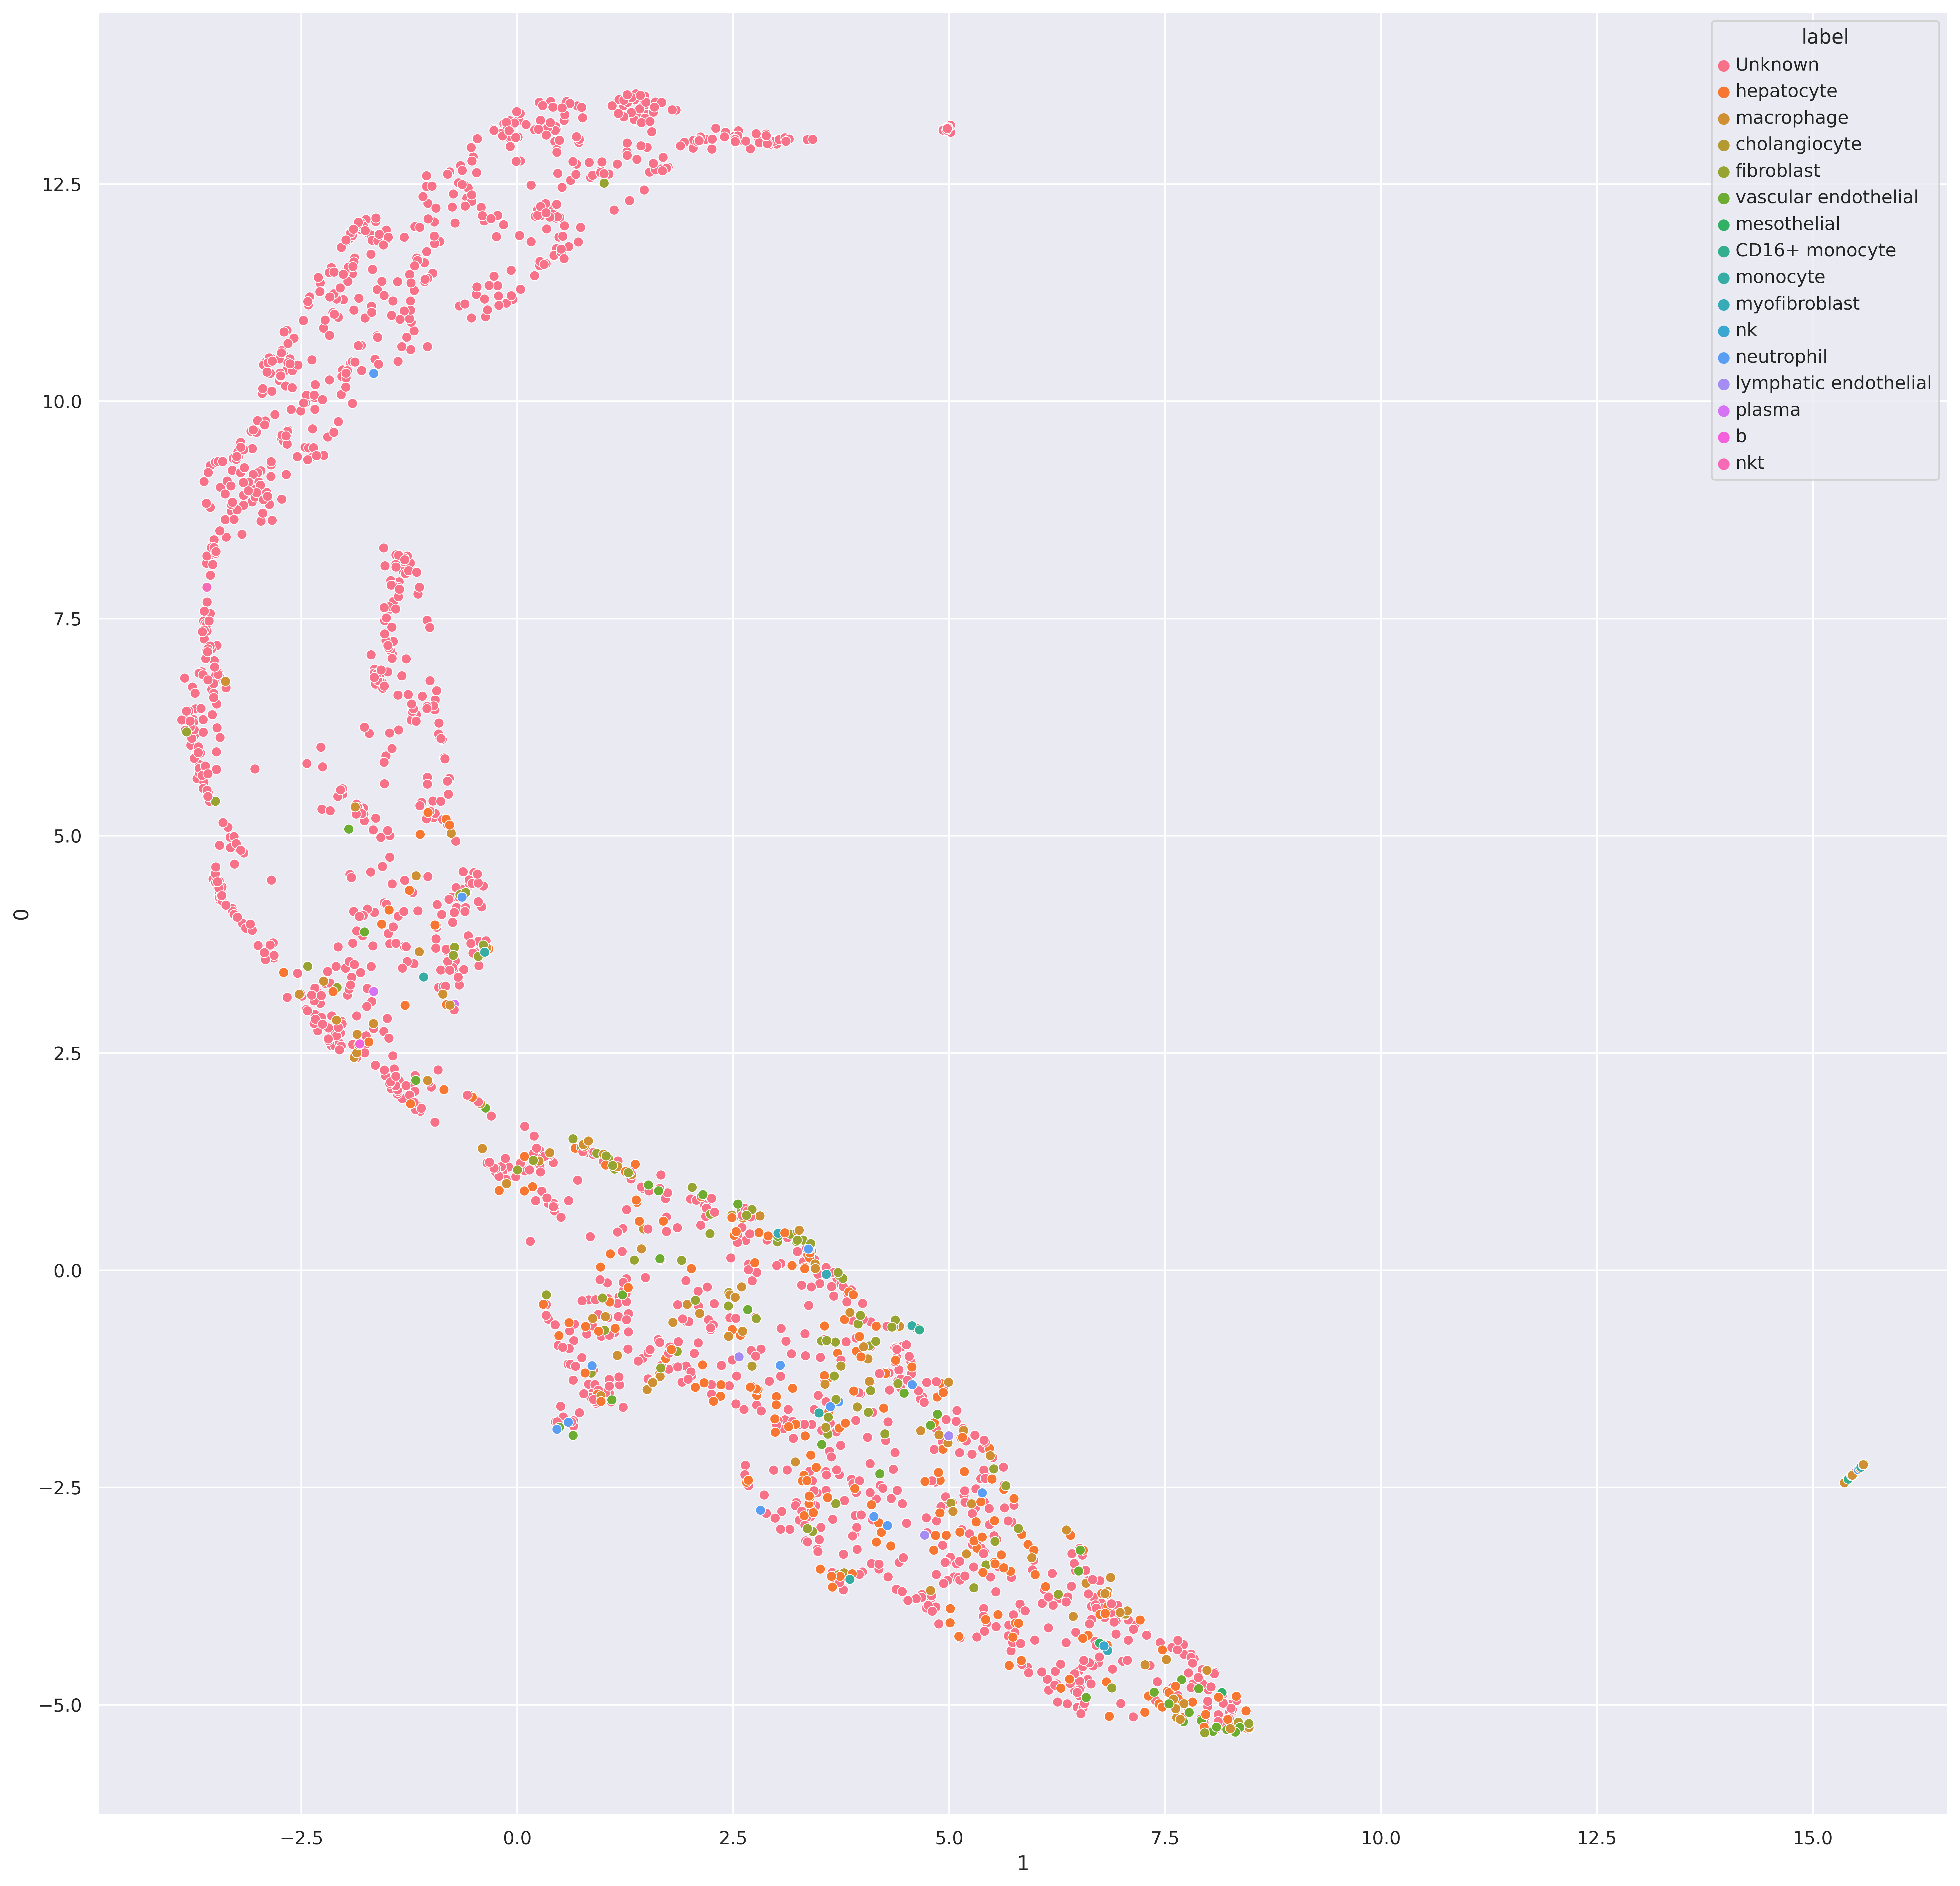

In [35]:
plt.figure(figsize=(20,20))

sns.scatterplot(
    embedding_df,
    x=1, y=0,
    hue="label",
    legend=True,
)


<Axes: xlabel='1', ylabel='0'>

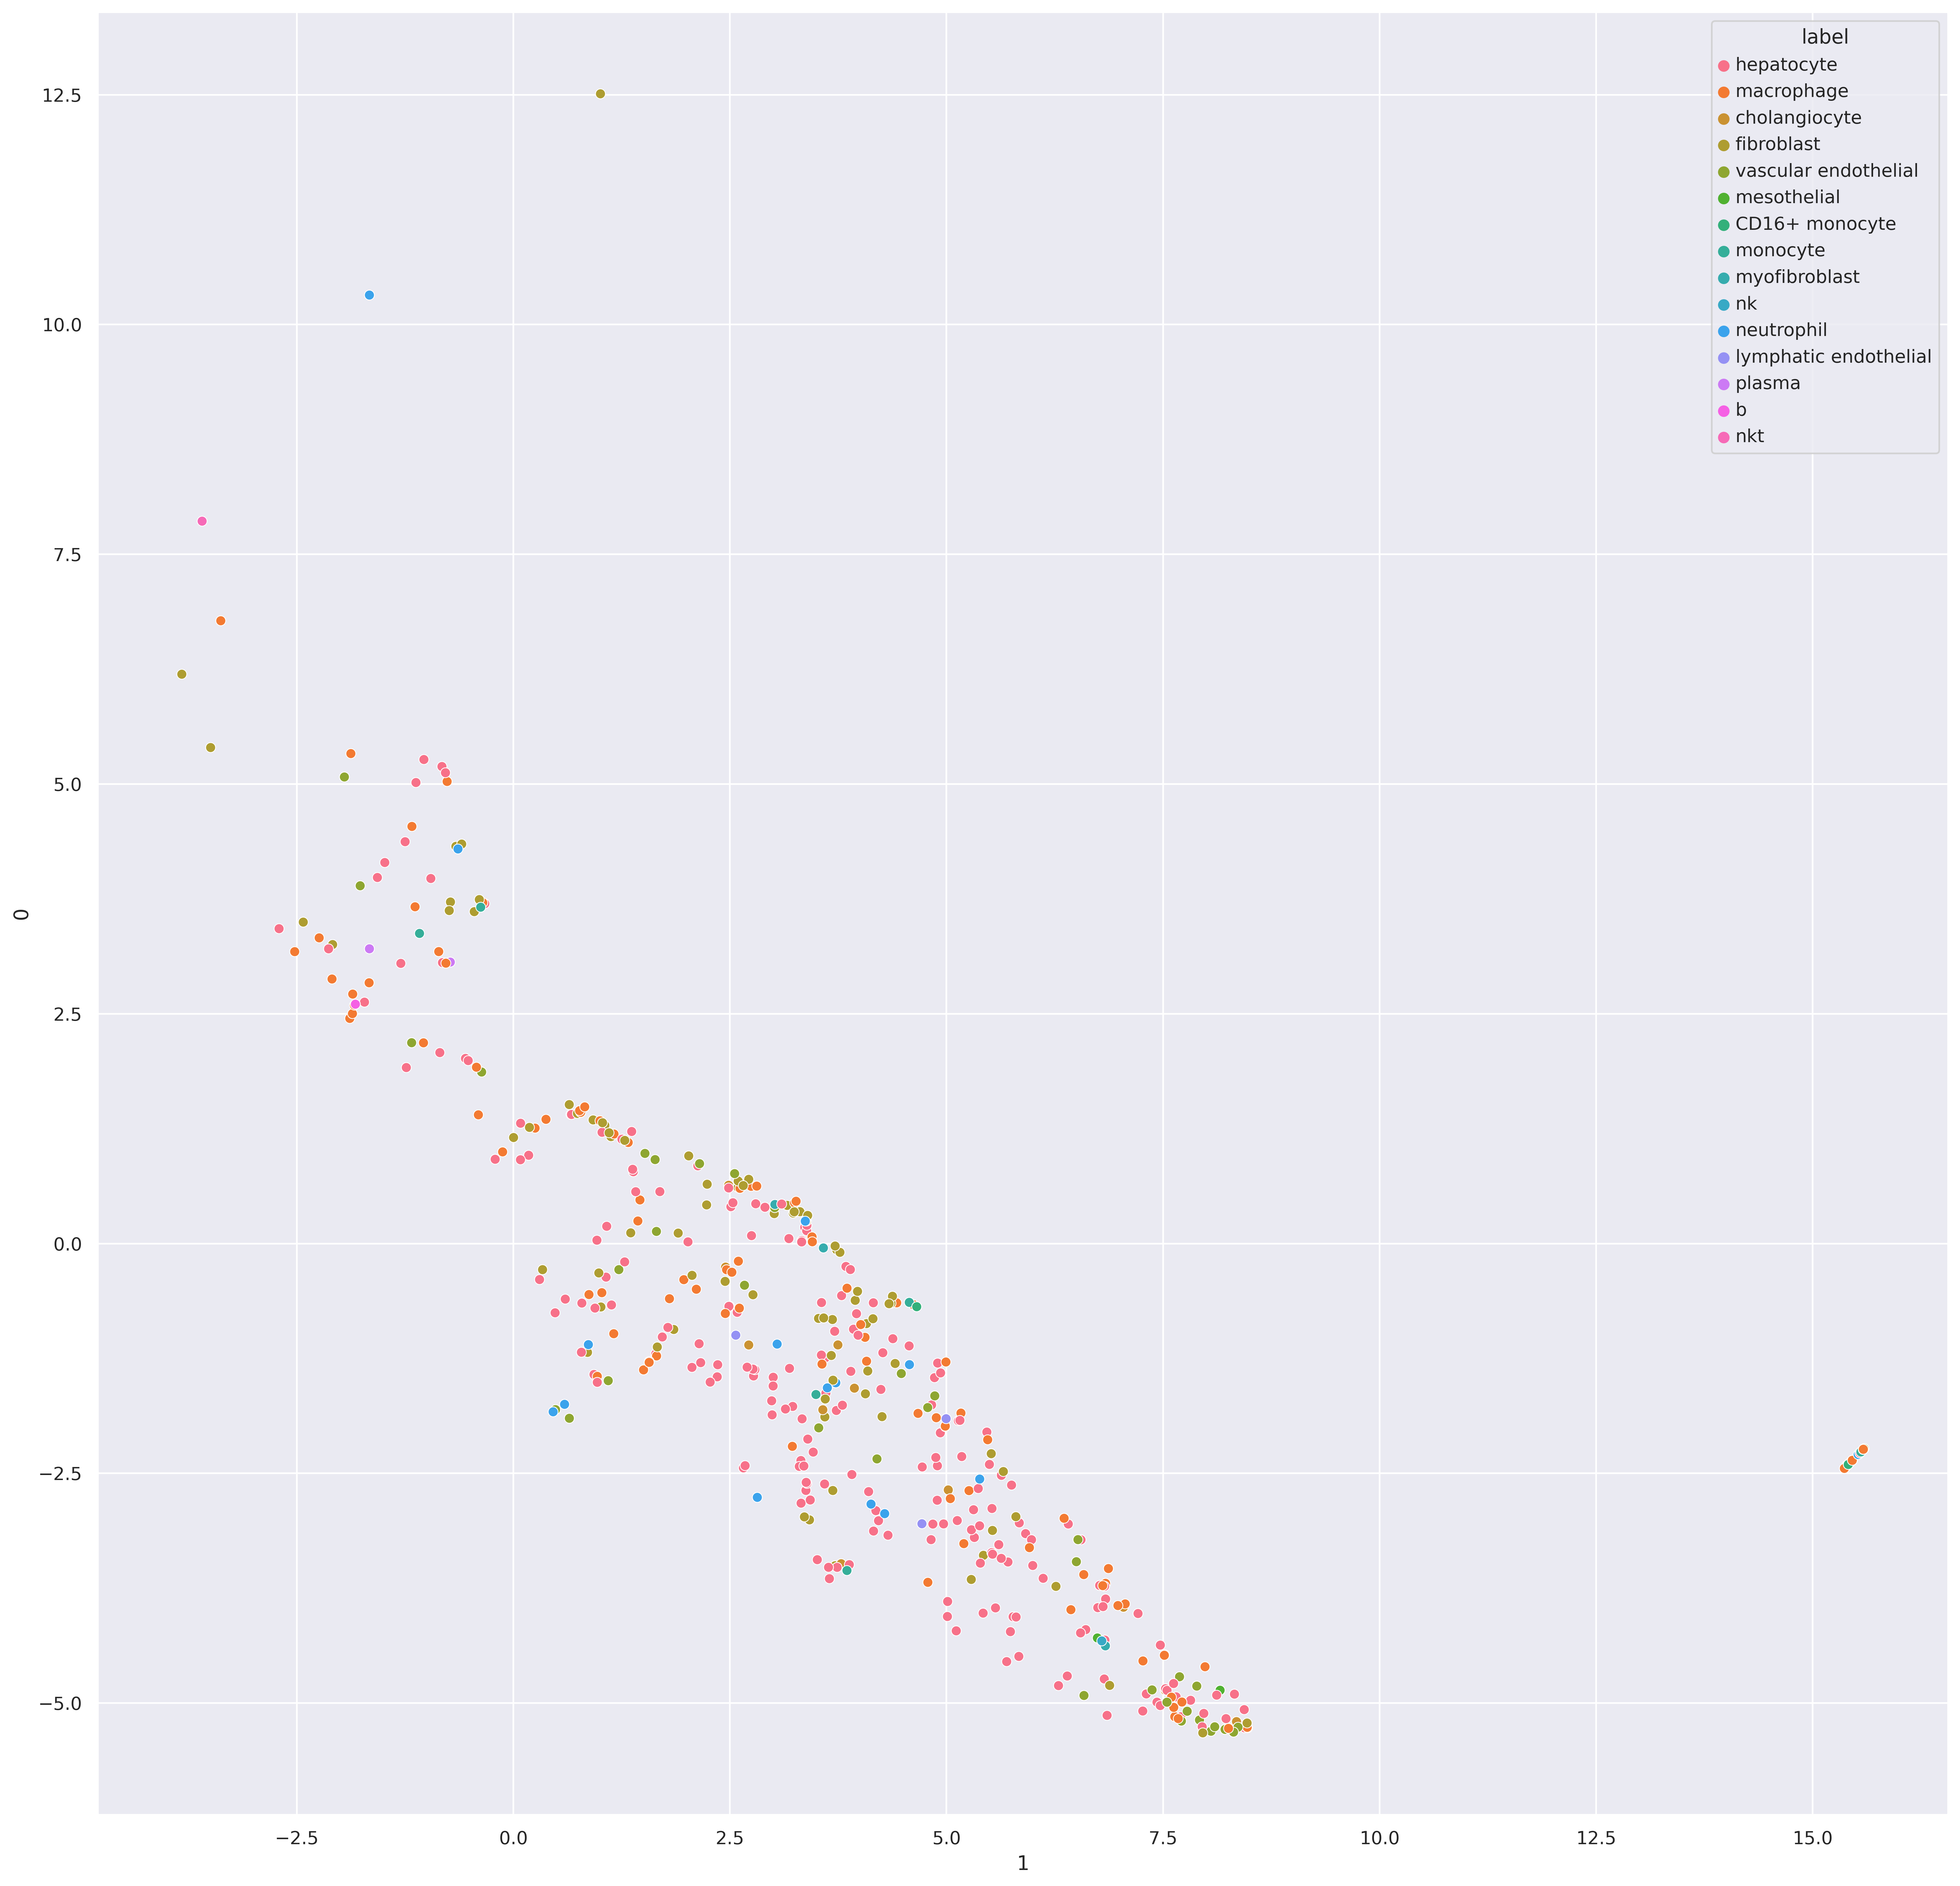

In [36]:
plt.figure(figsize=(20,20))

sns.scatterplot(
    embedding_df[embedding_df["label"]!="Unknown"],
    x=1, y=0,
    hue="label",
    legend=True,
)


This doesn't look good. The cell types are mixed.

In [38]:
to_save = pd.DataFrame(out.predictions)
to_save["index"] = input_to_model["index"]
to_save = to_save.set_index("index")

In [39]:
to_save["label"] = embedding_df["label"].values
to_save

0         1         2         3         4  \
index                                                                  
GGTGTCGTCCACCTCA-1  0.019446 -0.153330 -0.278318  0.164249 -0.021989   
CATTCCGGTCGAACGA-1  0.010809 -0.166326 -0.271252  0.158161 -0.027636   
TCACAAGAGACAGCGT-1  0.035513 -0.158929 -0.258002  0.160303  0.000043   
AGAGAATAGAAGCTGC-1  0.025086 -0.163285 -0.246495  0.127596  0.000186   
ACACAGTAGGCCATAG-1  0.031776 -0.151229 -0.217306  0.115698  0.018674   
...                      ...       ...       ...       ...       ...   
CTATCTAAGGTTGGAC-1 -0.125862 -0.071421 -0.356605  0.138877 -0.017156   
CATCCCACATACAGAA-1 -0.002114 -0.148442 -0.309766  0.142521 -0.000655   
TCGATTTAGTAATACG-1 -0.081290 -0.114030 -0.348925  0.148197 -0.006093   
TGGTAGTCAGAACATA-1 -0.125862 -0.071421 -0.356605  0.138877 -0.017156   
TAGTGCATCAAGTTGC-1 -0.125862 -0.071421 -0.356605  0.138877 -0.017156   

                           5         6         7         8         9  ...  \
index                                                                 ...   
GGTGTCGTCCACCTCA-1 -0.160254 -0.038581 -0.094466  0.144840 -0.061899  ...   
CATTCCGGTCGAACGA-1 -0.144682 -0.035615 -0.129476  0.146420 -0.050726  ...   
TCACAAGAGACAGCGT-1 -0.141538 -0.047350 -0.115062  0.149228 -0.031445  ...   
AGAGAATAGAAGCTGC-1 -0.147295 -0.031335 -0.132369  0.162034 -0.009032  ...   
ACACAGTAGGCCATAG-1 -0.134231 -0.052899 -0.138344  0.181737  0.001098  ...   
...                      ...       ...       ...       ...       ...  ...   
CTATCTAAGGTTGGAC-1 -0.207344 -0.134352  0.038306  0.140575 -0.175462  ...   
CATCCCACATACAGAA-1 -0.183262 -0.083725 -0.051639  0.137402 -0.103809  ...   
TCGATTTAGTAATACG-1 -0.206061 -0.130249 -0.001069  0.145054 -0.152665  ...   
TGGTAGTCAGAACATA-1 -0.207344 -0.134352  0.038306  0.140575 -0.175462  ...   
TAGTGCATCAAGTTGC-1 -0.207344 -0.134352  0.038306  0.140575 -0.175462  ...   

                          41        42        43        44        45  \
index                                                                  
GGTGTCGTCCACCTCA-1  0.087068  0.117094 -0.130094 -0.055968 -0.019310   
CATTCCGGTCGAACGA-1  0.068063  0.122207 -0.137912 -0.060735  0.003016   
TCACAAGAGACAGCGT-1  0.076202  0.102591 -0.139649 -0.047961  0.013308   
AGAGAATAGAAGCTGC-1  0.045941  0.102656 -0.141496 -0.037998  0.018116   
ACACAGTAGGCCATAG-1  0.031697  0.110494 -0.161310 -0.032262  0.040571   
...                      ...       ...       ...       ...       ...   
CTATCTAAGGTTGGAC-1  0.171883  0.057924 -0.117690 -0.038831 -0.064451   
CATCCCACATACAGAA-1  0.122070  0.117978 -0.136274 -0.069801 -0.039312   
TCGATTTAGTAATACG-1  0.152716  0.079513 -0.126193 -0.050285 -0.055965   
TGGTAGTCAGAACATA-1  0.171883  0.057924 -0.117690 -0.038831 -0.064451   
TAGTGCATCAAGTTGC-1  0.171883  0.057924 -0.117690 -0.038831 -0.064451   

                          46        47        48        49    label  
index                                                                
GGTGTCGTCCACCTCA-1  0.020081 -0.170195 -0.038031 -0.125144  Unknown  
CATTCCGGTCGAACGA-1  0.007866 -0.147321 -0.056335 -0.095594  Unknown  
TCACAAGAGACAGCGT-1 -0.019045 -0.130185 -0.026740 -0.105731  Unknown  
AGAGAATAGAAGCTGC-1 -0.012161 -0.144525 -0.023726 -0.103952  Unknown  
ACACAGTAGGCCATAG-1 -0.019056 -0.098948 -0.008678 -0.086905  Unknown  
...                      ...       ...       ...       ...      ...  
CTATCTAAGGTTGGAC-1  0.180759 -0.277693 -0.069600 -0.092403  Unknown  
CATCCCACATACAGAA-1  0.086099 -0.202537 -0.049528 -0.121922  Unknown  
TCGATTTAGTAATACG-1  0.147287 -0.247355 -0.060883 -0.108533  Unknown  
TGGTAGTCAGAACATA-1  0.180759 -0.277693 -0.069600 -0.092403  Unknown  
TAGTGCATCAAGTTGC-1  0.180759 -0.277693 -0.069600 -0.092403  Unknown  

[2142 rows x 51 columns]

In [40]:
to_save.to_csv("query_embeddings.csv")